In [169]:
import cv2

# Setup Haar Cascade (Deteksi Wajah)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [170]:
# Fungsi Augmentasi
def augment_image(img):
    augmented = []
    augmented.append(img)  # Original
    augmented.append(cv2.flip(img, 1))  # Flip Horizontal
    M = cv2.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), 10, 1)
    rotated = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    augmented.append(rotated)  # Rotated
    return augmented

In [ ]:
import glob
import cv2
import numpy as np

from skimage.feature import hog

# Fungsi Load & Preprocessing Data
def load_and_preprocess(folder_paths):
    X = []
    y = []
    for label, folder in enumerate(folder_paths):
        images = glob.glob(folder + '/*.jpg')
        for img_path in images:
            img = cv2.imread(img_path)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.3, 5)

            for (x, y_, w, h) in faces:
                roi = gray[y_:y_+h, x:x+w]

                # Augmentasi
                for face_aug in augment_image(roi):
                    face_aug = cv2.resize(face_aug, (42, 42))

                    # Ekstraksi fitur HOG
                    hog_features = hog(face_aug, orientations=9, pixels_per_cell=(8, 8),
                                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)

                    X.append(hog_features)
                    y.append(label)
                break  # satu wajah per gambar
    return np.array(X), np.array(y)

In [172]:
def load_and_convert_gray(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, gray

In [173]:
def detect_face_roi(gray_img):
    faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
    if len(faces) == 0:
        return None
    (x, y, w, h) = faces[0]
    roi = gray_img[y:y+h, x:x+w]
    roi_resized = cv2.resize(roi, (42, 42))
    return roi_resized

In [174]:
from skimage.feature import hog
from skimage import exposure

def get_hog_features(image):
    features, hog_image = hog(image,
                              orientations=9,
                              pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2),
                              block_norm='L2-Hys',
                              visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    return features, hog_image_rescaled

In [175]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
def visualize_all(original_img, roi_gray, hog_image, hog_features):
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 4, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title("Grayscale ROI")
    plt.imshow(roi_gray, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title("HOG Visualization")
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title("Flattened HOG Features")
    plt.plot(hog_features)
    plt.tight_layout()
    plt.show()

In [176]:
def run_full_pipeline(img_path):
    original, gray = load_and_convert_gray(img_path)
    roi = detect_face_roi(gray)
    if roi is None:
        print("No face detected.")
        return
    features, hog_img = get_hog_features(roi)
    visualize_all(original, roi, hog_img, features)


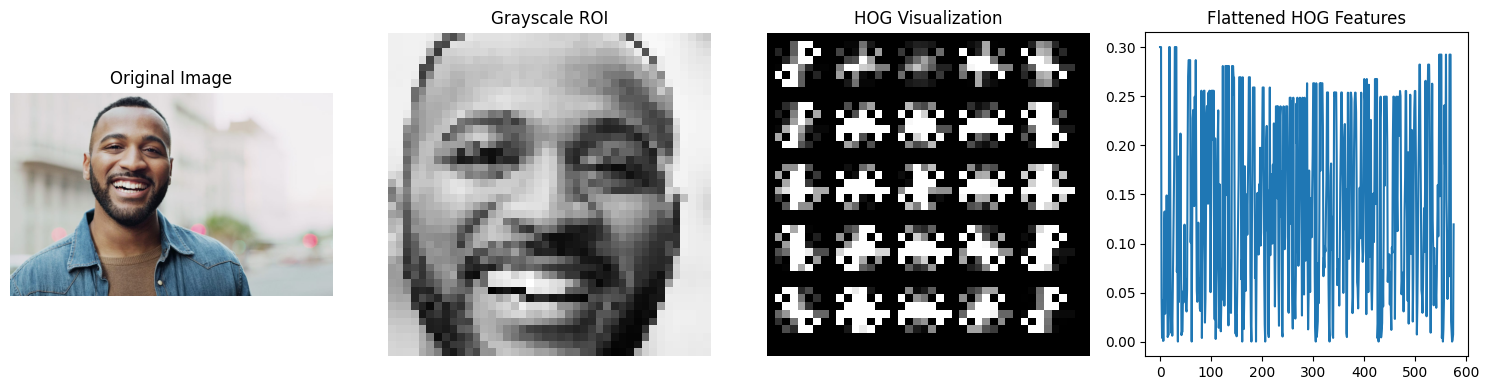

In [177]:
# Hasil Visualisasi Salah Satu Gambar
run_full_pipeline('./dataset/senang/05-12-21-happy-people.jpg')

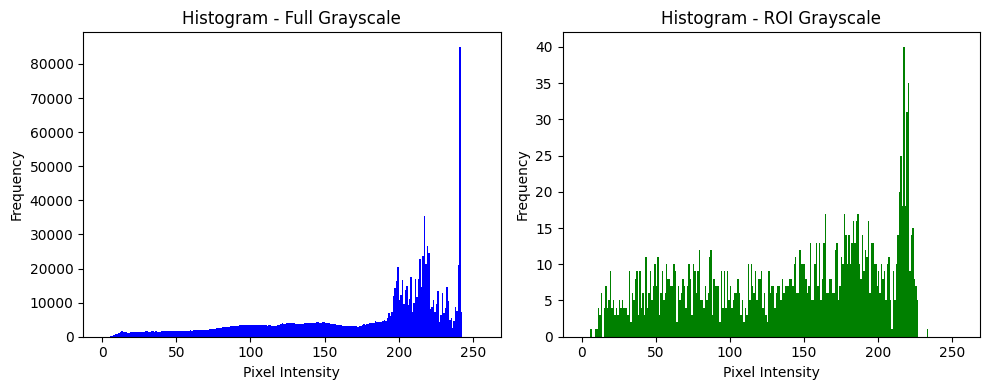

In [178]:
import matplotlib.pyplot as plt

img_ori_ex, img_gray_ex = load_and_convert_gray('./dataset/senang/05-12-21-happy-people.jpg')
img_roi_ex = detect_face_roi(img_gray_ex)

# Visualisasi Histogram
def visualize_histograms(full_gray, roi_gray):
    plt.figure(figsize=(10, 4))

    # Histogram gambar grayscale penuh
    plt.subplot(1, 2, 1)
    plt.title("Histogram - Full Grayscale")
    plt.hist(full_gray.ravel(), bins=256, range=[0, 256], color='blue')
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    # Histogram ROI grayscale
    plt.subplot(1, 2, 2)
    plt.title("Histogram - ROI Grayscale")
    plt.hist(roi_gray.ravel(), bins=256, range=[0, 256], color='green')
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

visualize_histograms(img_gray_ex, img_roi_ex)

In [179]:
# Load Dataset
folder_paths = ['dataset/senang', 'dataset/sedih', 'dataset/marah']  # ganti sesuai folder dataset lu
X, y = load_and_preprocess(folder_paths)
print(f'Dataset shape after augmentasi: {X.shape}')

Dataset shape after augmentasi: (318, 576)


In [180]:
from sklearn.model_selection import train_test_split

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [181]:
from sklearn.preprocessing import StandardScaler

# Normalisasi Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [182]:
from sklearn.svm import SVC

# Initialize SVM
svm_linear = SVC(kernel='linear')
svm_rbf = SVC(kernel='rbf', gamma='scale')

In [183]:
# Train Data (Linear)
svm_linear.fit(X_train, y_train)

SVC(kernel='linear')

In [184]:
# Train Data (RBF)
svm_rbf.fit(X_train, y_train)

SVC()

In [185]:
# Testing (Linear)
y_pred_linear = svm_linear.predict(X_test)

In [186]:
# Testing (RBF)
y_pred_rbf = svm_rbf.predict(X_test)

In [187]:
from sklearn.metrics import accuracy_score, confusion_matrix

# 10. Evaluasi
print("\n==== HASIL LINEAR SVM ====")
print("Accuracy:", accuracy_score(y_test, y_pred_linear))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_linear))

print("\n==== HASIL RBF SVM ====")
print("Accuracy:", accuracy_score(y_test, y_pred_rbf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rbf))


==== HASIL LINEAR SVM ====
Accuracy: 0.71875
Confusion Matrix:
 [[20  2  5]
 [ 2  4  4]
 [ 5  0 22]]

==== HASIL RBF SVM ====
Accuracy: 0.765625
Confusion Matrix:
 [[23  0  4]
 [ 1  1  8]
 [ 2  0 25]]
